# Инференс и валидация

Теперь, когда у вас есть обученная сеть, вы можете использовать её для прогнозирования. Это обычно называется **инференсом** (inference). Однако нейронные сети имеют тенденцию показывать *слишком хорошие* результаты на обучающих данных и не могут обобщать свою работу на данные, которые не были доступны при обучении. Это называется **переобучением**, и оно ухудшает качество инференса. Чтобы проверить наличие переобучения в процессе обучения, мы измеряем метрики на данных, не входящих в обучающий набор, которые называют **валидационным** набором. Мы избегаем переобучения с помощью регуляризации, такой как дроп-аут, в то время как следим за метриками на валидационной выборке в процессе обучения. В этом блокноте покажем, как это сделать в PyTorch. 

Как обычно, давайте начнём с загрузки набора данных через torchvision. Вы узнаете больше о torchvision и загрузке данных в следующей части. На этот раз мы воспользуемся тестовым набором, который вы можете получить, установив `train=False`:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

Тестовый набор содержит изображения, точно так же, как и тренировочный набор. Обычно вы увидите, что 10-20% оригинального набора данных отложены для тестирования и валидации, а оставшаяся часть используется для обучения.

In [1]:
import torch
from torchvision import datasets, transforms

# Определим трансформацию для нормализации данных
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Загрузим тренировочные данные
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Загрузим тестовые данные
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

c:\Users\user1\anaconda3\envs\YOLO\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\user1\anaconda3\envs\YOLO\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Создадим модель нейронной сети.

In [2]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # убедимся, что входной тензор развернут в вектор-строку (flattened)
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

Цель валидации состоит в том, чтобы измерить метрики модели на данных, которые не входят в тренировочный набор. Выбор метрик зависит во многом от разработчика. Обычно это просто точность (accuracy), процент классов, которые сеть предсказывает правильно. Другие варианты включают [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) и top-5 error rate. Здесь мы сосредоточимся на точности. Сначала сделаем прямой проход с одним батчем из тестового набора.

In [3]:
model = Classifier()

images, labels = next(iter(testloader))
# Получим вероятности классов
ps = torch.exp(model(images))
# Убедимся, что форма правильная, мы должны получить 10 вероятностей классов для 64 примеров
print(ps.shape)

torch.Size([64, 10])


С вероятностями мы можем получить наиболее вероятный класс, используя метод `ps.topk`. Это возвращает $k$ наивысших значений. Поскольку мы просто хотим наиболее вероятный класс, мы можем использовать `ps.topk(1)`. Это возвращает кортеж из наивысших значений и соответствующих индексов. Если наивысшее значение является пятым элементом, мы получим 4 как индекс.

In [ ]:
top_p, top_class = ps.topk(1, dim=1)
# Посмотрим на наиболее вероятные классы для первых 10 примеров
print(top_class[:10,:])

tensor([[9],
        [9],
        [9],
        [9],
        [9],
        [9],
        [9],
        [9],
        [9],
        [9]])


Теперь мы можем проверить, совпадают ли предсказанные классы с метками. Это легко сделать, сравнив `top_class` и `labels`, но мы должны быть осторожны с формами. Здесь `top_class` — это 2D тензор с формой `(64, 1)`, а `labels` — это 1D с формой `(64)`. Чтобы получить нужное равенство, `top_class` и `labels` должны иметь одинаковую форму.

Если мы сделаем

```python
equals = top_class == labels
```

`equals` будет иметь форму `(64, 64)`. Происходит сравнение одного элемента в каждой строке `top_class` с каждым элементом в `labels`, что возвращает 64 значения True/False для каждой строки.

In [5]:
equals = top_class == labels.view(*top_class.shape)

Теперь нам нужно рассчитать процент правильных предсказаний. `equals` имеет двоичные значения, либо 0, либо 1. Это означает, что если мы просто суммируем все значения и делим на количество значений, мы получим процент правильных предсказаний. Это та же операция, что и вычисление среднего, поэтому мы можем получить точность с помощью вызова `torch.mean`. Если бы все было так просто. Если вы попробуете `torch.mean(equals)`, вы получите ошибку

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

Это происходит потому, что `equals` имеет тип `torch.ByteTensor`, но для этого типа `torch.mean` не реализован. Поэтому нам нужно преобразовать `equals` в float тензор с плавающей запятой. Обратите внимание, что когда мы вызываем `torch.mean`, это возвращает скалярный тензор. Чтобы получить фактическое значение как float, нам нужно будет использовать `accuracy.item()`.

In [6]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Точность: {accuracy.item()*100}%')

Точность: 12.5%


Сеть не обучена, поэтому она делает случайные предположения, и мы должны увидеть точность около 10%. Теперь давайте обучим нашу сеть и включим шаг валидации, чтобы измерить, насколько хорошо сеть работает на тестовом наборе. Поскольку мы не обновляем параметры в цикле валидации, мы можем ускорить процесс, отключив градиенты с помощью `torch.no_grad()`:

```python
# отключение градиентов
with torch.no_grad():
    # валидация
    for images, labels in testloader:
        ...
```

>**Упражнение:** Реализуйте обучение сети совместно с циклом валидации.

In [13]:
## TODO

model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, val_losses, train_acc, val_acc = [], [], [], []

for e in range(epochs):
    accuracy = 0
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        running_loss += loss.item()
    accuracy /= len(trainloader)
    train_acc.append(accuracy)
    train_losses.append(running_loss/len(trainloader))
    
    ## TODO: Реализуйте цикл валидации и вывод точности на валидационной выборке
    with torch.no_grad():
        accuracy = 0
        total_loss = 0
        for images, labels in testloader:
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            total_loss += loss.item()
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        accuracy /= len(testloader)
        val_acc.append(accuracy)
        val_losses.append(total_loss/len(testloader))
            
    print(f'epoch {e+1}/{epochs} : loss = {round(train_losses[-1],3)}, val_loss = {round(val_losses[-1],3)}, train_acc: {round(train_acc[-1],3)}, val_acc: {round(val_acc[-1],3)}')

epoch 1/30 : loss = 0.523, val_loss = 0.441, train_acc: 0.809, val_acc: 0.844
epoch 2/30 : loss = 0.392, val_loss = 0.42, train_acc: 0.857, val_acc: 0.85
epoch 3/30 : loss = 0.356, val_loss = 0.388, train_acc: 0.869, val_acc: 0.866
epoch 4/30 : loss = 0.337, val_loss = 0.37, train_acc: 0.876, val_acc: 0.866
epoch 5/30 : loss = 0.319, val_loss = 0.4, train_acc: 0.883, val_acc: 0.856
epoch 6/30 : loss = 0.303, val_loss = 0.386, train_acc: 0.888, val_acc: 0.867
epoch 7/30 : loss = 0.296, val_loss = 0.362, train_acc: 0.892, val_acc: 0.874
epoch 8/30 : loss = 0.282, val_loss = 0.355, train_acc: 0.895, val_acc: 0.876
epoch 9/30 : loss = 0.276, val_loss = 0.359, train_acc: 0.898, val_acc: 0.876
epoch 10/30 : loss = 0.267, val_loss = 0.355, train_acc: 0.901, val_acc: 0.877
epoch 11/30 : loss = 0.261, val_loss = 0.374, train_acc: 0.904, val_acc: 0.871
epoch 12/30 : loss = 0.254, val_loss = 0.374, train_acc: 0.907, val_acc: 0.878
epoch 13/30 : loss = 0.247, val_loss = 0.368, train_acc: 0.908, va

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

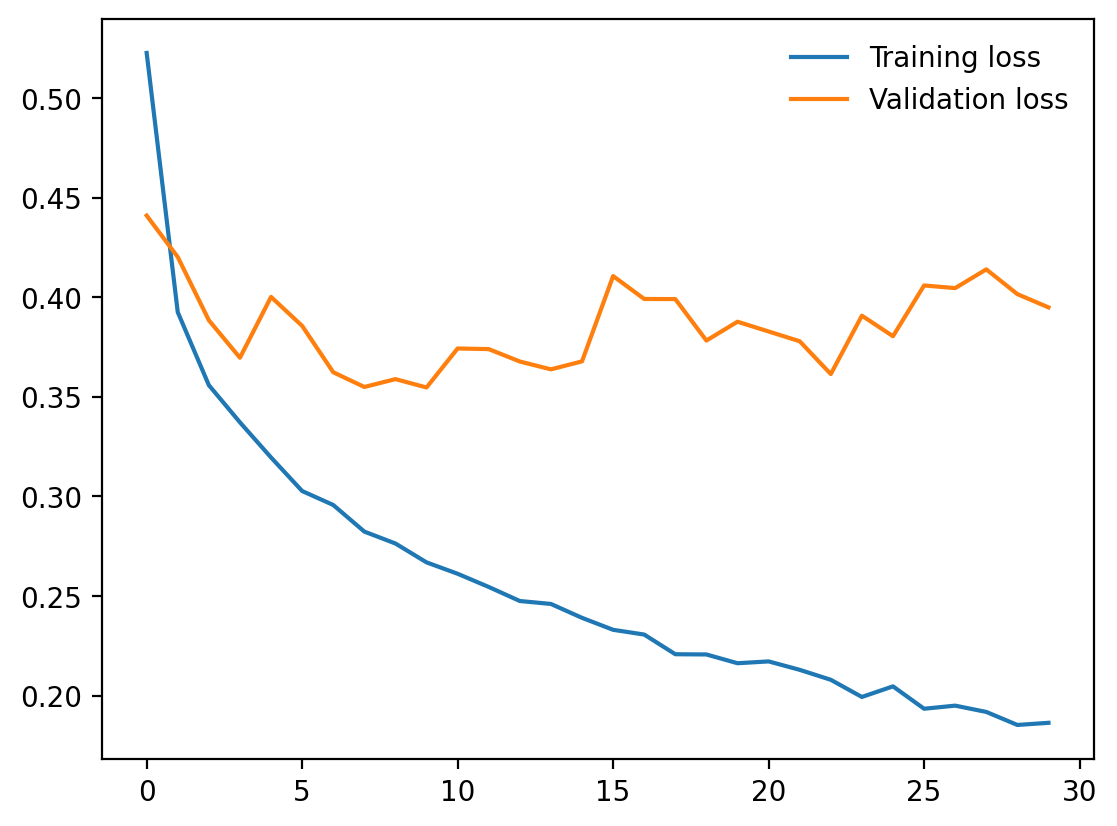

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

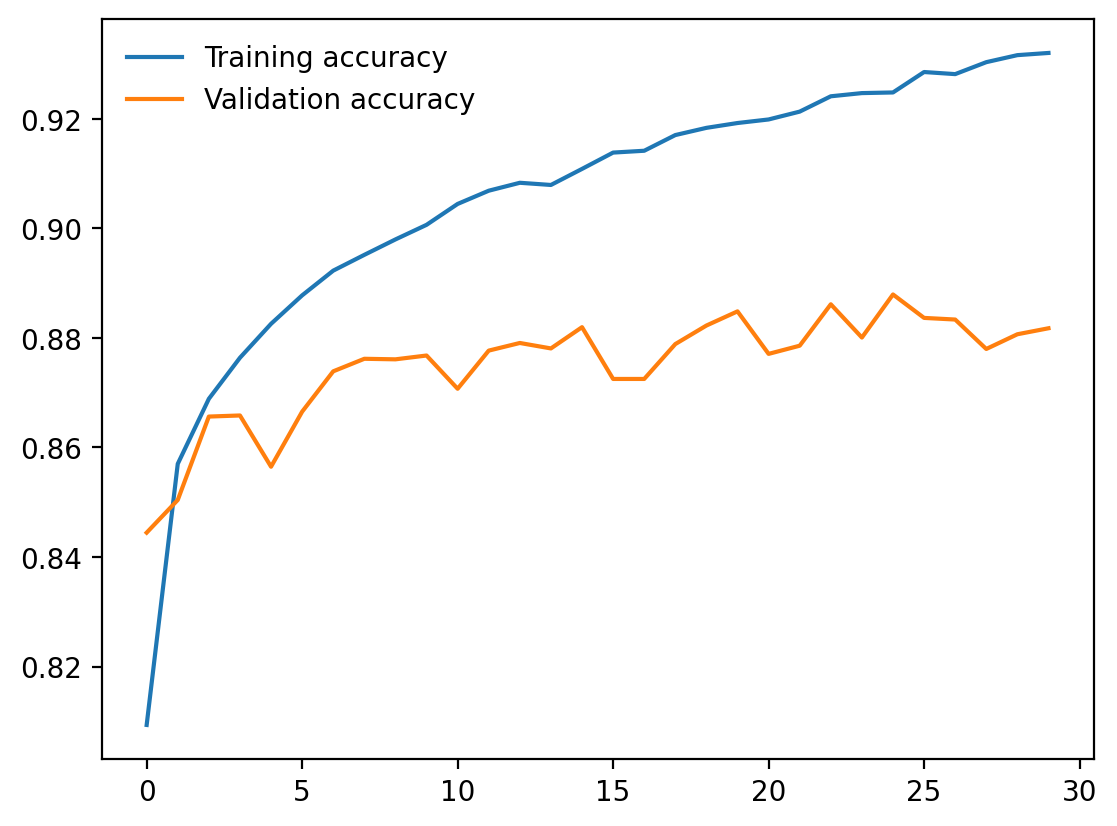

In [16]:
plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.show()

## Переобучение (overfitting)

Если мы посмотрим на функцию потерь при обучении и валидации по мере обучения сети, мы можем увидеть явление, известное как переобучение (overfitting).

<img src='assets/overfitting.png' width=450px>

Сеть учит тренировочный набор всё лучше и лучше, что приводит к снижению потерь при обучении. Однако она начинает испытывать проблемы с обобщением данных, выходящих за пределы тренировочного набора, что приводит к росту потерь на валидации. Конечная цель любой модели глубокого обучения — делать предсказания на новых данных, поэтому мы должны стремиться получить как можно более низкую потерю на валидации. Один из вариантов — использовать версию модели с наименьшей потерей на валидации, здесь это версия примерно через 8-10 эпох обучения. Эта стратегия называется *ранней остановкой* (early-stopping). На практике вы будете сохранять модель регулярно, пока обучаете её, а затем позже выбирать модель с наименьшей потерей на валидации.

Наиболее распространённым методом снижения переобучения (помимо ранней остановки) является *дроп-аут* (dropout), когда мы случайным образом исключаем узлы. Это заставляет сеть делиться информацией между весами, увеличивая её способность обобщать работу на новые данные. Добавить дроп-аут в PyTorch очень просто, используя модуль [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout).

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Модуль дропаута с вероятностью исключения 0.2
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # убедимся, что входной тензор развернут (flattened)
        x = x.view(x.shape[0], -1)
        
        # Теперь с дроп-аутом
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # вывод, поэтому без дропаута
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

Во время обучения мы хотим использовать дроп-аут, чтобы предотвратить переобучение, но во время инференса мы хотим использовать всю сеть. Поэтому нам нужно отключить дроп-аут во время валидации, тестирования и когда мы используем сеть для предсказаний. Для этого используйте `model.eval()`. Это устанавливает модель в режим валидации (evaluation mode), где вероятность дропаута равна 0. Вы можете снова включить дроп-аут, установив модель в режим обучения с помощью `model.train()`. В общем, структура цикла валидации будет выглядеть следующим образом: вы отключаете градиенты, устанавливаете модель в режим валидации, вычисляете функцию потерь и метрики валидации, а затем возвращаете модель в режим обучения.

```python
# отключение градиентов
with torch.no_grad():
    
    # установить модель в режим оценки
    model.eval()
    
    # валидационный проход здесь
    for images, labels in testloader:
        ...

# вернуть модель в режим обучения
model.train()
```

> **Упражнение:** Добавьте дроп-аут в вашу модель и обучите её снова на Fashion-MNIST. Посмотрите, сможете ли вы получить более низкую потерю на валидации.

In [17]:
## TODO: Определите модель с добавленным дроп-аутом
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # убедимся, что входной тензор развернут в вектор-строку (flattened)
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [19]:
## TODO: Обучите модель с дроп-аутом, добавьте мониторинг обучения с расчетом функции потерь и точности на валидационной выборке

model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, val_losses, train_acc, val_acc = [], [], [], []

for e in range(epochs):
    model.train()
    accuracy = 0
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        running_loss += loss.item()
    accuracy /= len(trainloader)
    train_acc.append(accuracy)
    train_losses.append(running_loss/len(trainloader))
    
    ## TODO: Реализуйте цикл валидации и вывод точности на валидационной выборке
    with torch.no_grad():
        model.eval()
        accuracy = 0
        total_loss = 0
        for images, labels in testloader:
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            total_loss += loss.item()
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        accuracy /= len(testloader)
        val_acc.append(accuracy)
        val_losses.append(total_loss/len(testloader))
            
    print(f'epoch {e+1}/{epochs} : loss = {round(train_losses[-1],3)}, val_loss = {round(val_losses[-1],3)}, train_acc: {round(train_acc[-1],3)}, val_acc: {round(val_acc[-1],3)}')

epoch 1/30 : loss = 0.604, val_loss = 0.472, train_acc: 0.785, val_acc: 0.822
epoch 2/30 : loss = 0.483, val_loss = 0.442, train_acc: 0.831, val_acc: 0.844
epoch 3/30 : loss = 0.451, val_loss = 0.439, train_acc: 0.842, val_acc: 0.843
epoch 4/30 : loss = 0.433, val_loss = 0.4, train_acc: 0.847, val_acc: 0.854
epoch 5/30 : loss = 0.423, val_loss = 0.393, train_acc: 0.851, val_acc: 0.855
epoch 6/30 : loss = 0.415, val_loss = 0.411, train_acc: 0.854, val_acc: 0.861
epoch 7/30 : loss = 0.407, val_loss = 0.391, train_acc: 0.857, val_acc: 0.862
epoch 8/30 : loss = 0.401, val_loss = 0.39, train_acc: 0.861, val_acc: 0.857
epoch 9/30 : loss = 0.393, val_loss = 0.396, train_acc: 0.862, val_acc: 0.863
epoch 10/30 : loss = 0.39, val_loss = 0.428, train_acc: 0.863, val_acc: 0.85
epoch 11/30 : loss = 0.385, val_loss = 0.384, train_acc: 0.865, val_acc: 0.868
epoch 12/30 : loss = 0.387, val_loss = 0.382, train_acc: 0.865, val_acc: 0.87
epoch 13/30 : loss = 0.381, val_loss = 0.384, train_acc: 0.868, val

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

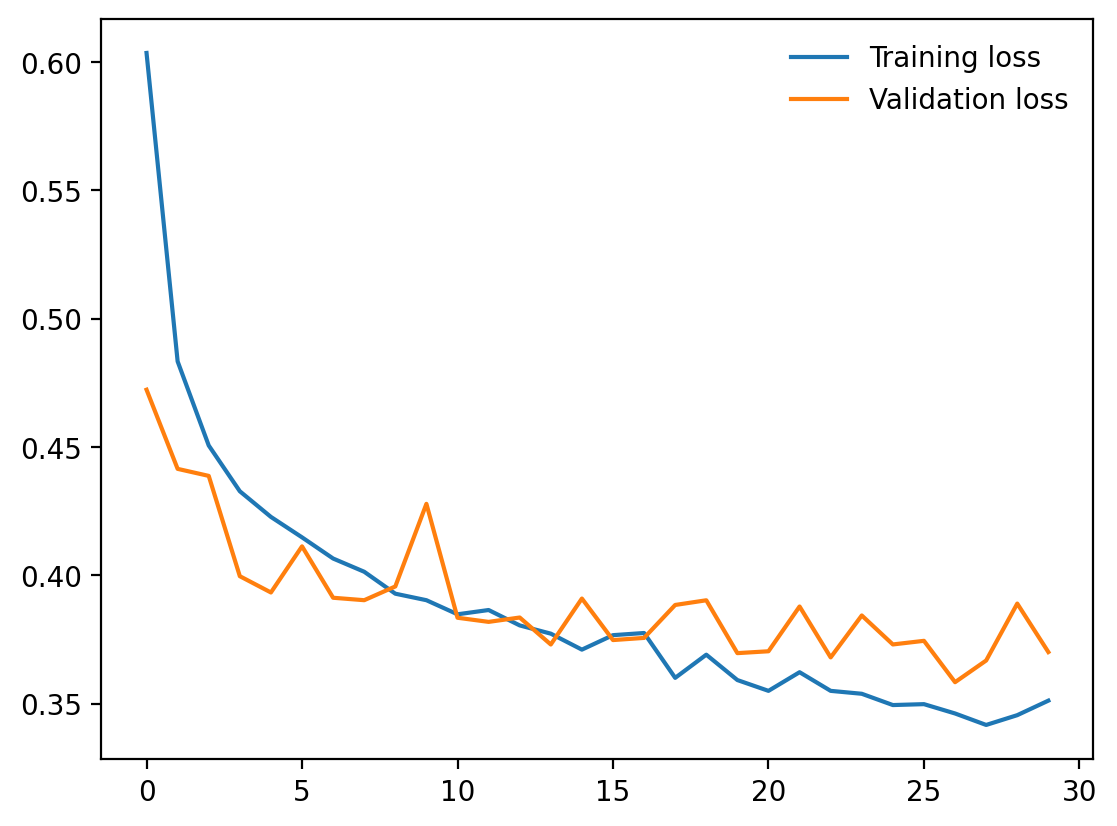

In [21]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

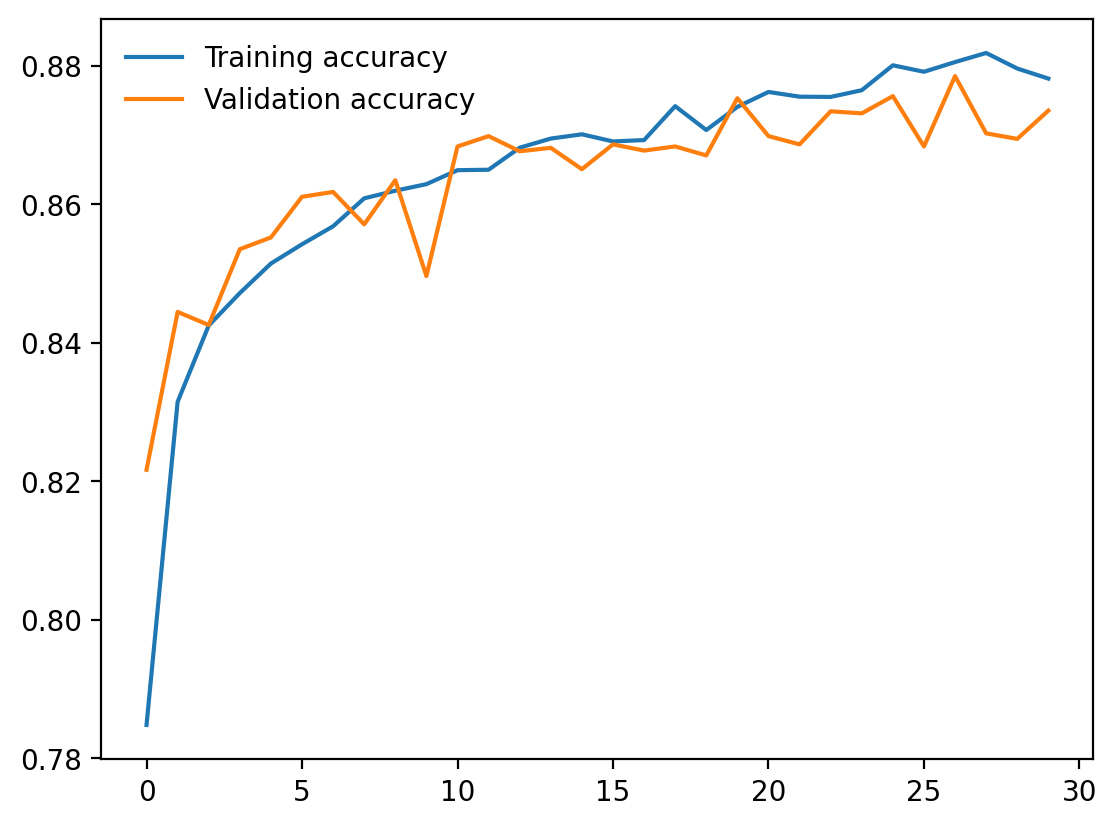

In [22]:
plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.show()

## Инференс (inference)

Теперь, когда модель обучена, мы можем использовать её для инференса. Мы уже делали это раньше, но теперь нам нужно помнить о установке модели в режим валидации с `model.eval()`. Также можно отключить autograd с помощью менеджера контекста `torch.no_grad()`.

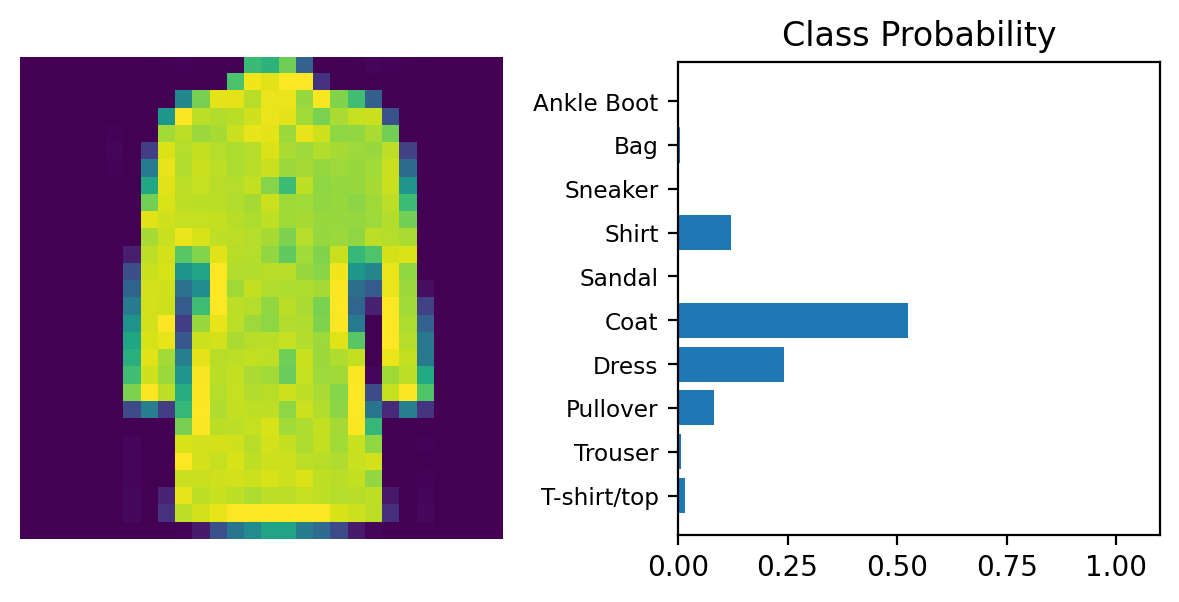

In [24]:
# Импортируем вспомогательный модуль (должен находиться в репозитории)
import helper

# Примените свою сеть.

model.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]
# Преобразуем 2D изображение в 1D вектор
img = img.view(1, 784)

# Рассчитаем вероятности классов (softmax) для img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Построим изображение и вероятности
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

В следующей части будет продемонстрировано, как сохранить ваши обученные модели. Обычно вы не хотите обучать модель каждый раз, когда она вам нужна. Вместо этого вы будете обучать один раз, сохранять её, а затем загружать модель, когда захотите обучить подольше или использовать её для инференса.